HHU Deep Learning, SS2025, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 02 - Rotation prediction as a pretext task
---

Submit the solved notebook (not a zip) with your full name plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 02.05.2025 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/e0cYundCC8FG8QS](https://uni-duesseldorf.sciebo.de/s/e0cYundCC8FG8QS)

---



## Introduction to rotatation prediction


Rotation prediction provides a simple, yet effective way to learn rich representations from unlabeled image data.

The basic idea behind rotation prediction is that the network is trained to predict the orientation of a given image after it has been rotated by a certain angle (e.g., 0°, 90°, 180°, or 270°).

By doing so, the network is forced to learn features that are invariant to rotation, which can be very useful for downstream tasks such as object recognition or image classification.

Rotation prediction is also a relatively simple task that can be applied to large amounts of unlabeled data, which makes it a good choice for pretraining neural networks.

Therefore, it has become a popular choice for pretraining in many computer vision tasks.

In this exercise, we will train a ResNet18 on the task of rotation prediction on the STL10 dataset.

Related paper: [UNSUPERVISED REPRESENTATION LEARNING BY PREDICTING IMAGE ROTATIONS](https://arxiv.org/pdf/1803.07728.pdf)


# Part I. Basic imports


In [1]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week02/utils.py

File ‘utils.py’ already there; not retrieving.



In [2]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import STL10
import matplotlib.pyplot as plt

from utils import *

In [4]:
os.makedirs("./models")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
num_workers = 2 if torch.cuda.is_available() else 0

# Task 1: Preparing the data

One way to apply rotations while loading the data is to create a `Dataset` class.
Instead of returning a tuple of `(img, label)` the dataset will now return `(img, rotation_class_id)`



torch.Size([4, 3, 96, 96]) tensor([1, 0, 2, 0])
torch.Size([4, 3, 96, 96]) torch.Size([4])


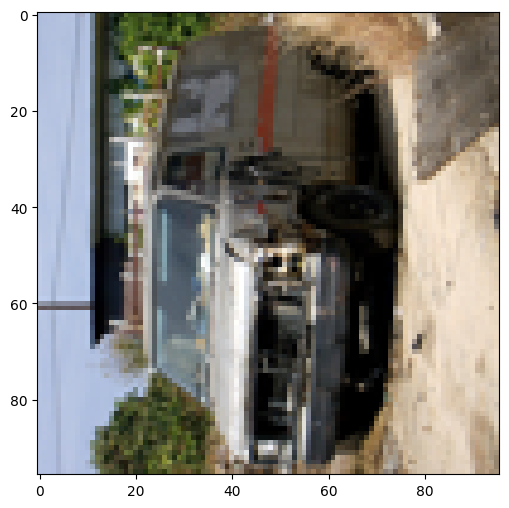

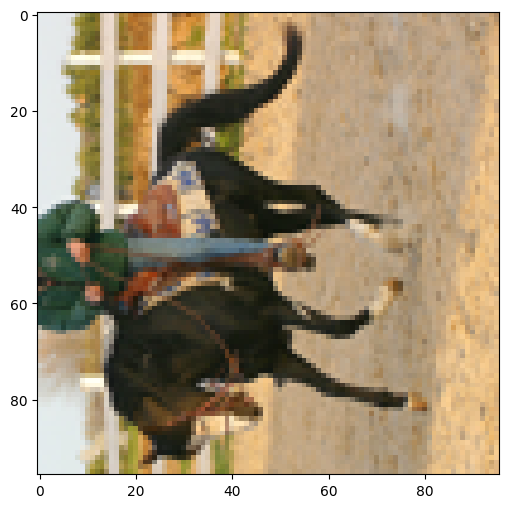

In [5]:
class STL10Rot(Dataset):
    ### START CODE HERE ### (> 10 line)
    def __init__(self, split, transform=None):
        self.data = STL10(root='../data', split=split, transform=transform, download=True)
        self.classes = torch.arange(4)

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        img, _ = self.data[idx]
        rotation = torch.randint(0, 4, ()).item()
        return TF.rotate(img, rotation * 90), rotation
    ### END CODE HERE ###


def load_data(batch_size=128, train_split="unlabeled", test_split="test", rotated=True):
    # Returns a train and validation dataloader for STL10 dataset
    transf = T.Compose([T.ToTensor()])
    if rotated:
        train_ds = STL10Rot(split=train_split, transform=transf)
        val_ds = STL10Rot(split=test_split, transform=transf)
    else:
        train_ds = STL10(root='../data', split=train_split, transform=transf, download=True)
        val_ds = STL10(root='../data', split=test_split, transform=transf, download=True)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_dl, val_dl


def test_load_data():
    train_dl, val_dl = load_data(batch_size=4)
    for i, (x, y) in enumerate(train_dl):
        print(x.shape, y)
        plt.figure(figsize=(6, 6))
        imshow(x[0, ...])
        break
    for i, (x, y) in enumerate(val_dl):
        print(x.shape, y.shape)
        plt.figure(figsize=(6, 6))
        imshow(x[0, ...])
        break


test_load_data()

# Task 2: Load and modify Resnet18

Your task is to load and mofidy the Resnet18 architecture.

Which layers do you need to modify?

In [6]:
def load_resnet():
    ### START CODE HERE ### ( 4 line)
    model = torchvision.models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 4)
    return model
    ### END CODE HERE ###


def test_load_resnet():
    model = load_resnet()
    train_dl, _ = load_data(batch_size=4)
    x, target = next(iter(train_dl))
    y = model(x)
    loss = F.cross_entropy(y, target)
    print(y.shape, target.shape, loss)


test_load_resnet()

torch.Size([4, 4]) torch.Size([4]) tensor(1.3056, grad_fn=<NllLossBackward0>)


# Task 3: Launch training!
Choose the model and hyperparameters and launch the training.\
You can use the `pretrain` function from `utils.py`.\
It will store the best checkpoint (based on validation loss) in `best_model_min_val_loss.pth`.

The training should not take more than 1h (~50 mins with our setup).

In [7]:
### START CODE HERE ###
model = load_resnet().to(device)
train_dl, val_dl = load_data(batch_size=128)

num_epochs = 40
lr = 1e-3

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [8]:
pretrain(model, optimizer, num_epochs, train_dl, val_dl, criterion, device)
### END CODE HERE ###

  0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

{'train_loss': [np.float64(0.9336952829299985),
  np.float64(0.739164190371628),
  np.float64(0.6456369864742469),
  np.float64(0.5828534584597248),
  np.float64(0.5352624482129846),
  np.float64(0.4973140449627586),
  np.float64(0.46176610216307823),
  np.float64(0.4340301159855045),
  np.float64(0.4114657939623689),
  np.float64(0.385641203188073),
  np.float64(0.3679835725470882),
  np.float64(0.34600024371195937),
  np.float64(0.3262063416716693),
  np.float64(0.31057269831218987),
  np.float64(0.2935748245671887),
  np.float64(0.2780507680247812),
  np.float64(0.25957143542063815),
  np.float64(0.24546034704617528),
  np.float64(0.22857243186601287),
  np.float64(0.21437822954009866),
  np.float64(0.20110656034268076),
  np.float64(0.18658335395443165),
  np.float64(0.17356623132782215),
  np.float64(0.16466194910504628),
  np.float64(0.15412848858672487),
  np.float64(0.14222446079735104),
  np.float64(0.1343882267680162),
  np.float64(0.1227488009702138),
  np.float64(0.11732045

# Task 4: Loading the best model and visualizing reconstructions

Use the validation split to visualize the rotated images and their predicted angles VS the applied ones.
Visualize 16 predictions in a 4x4 grid as illustrated below.

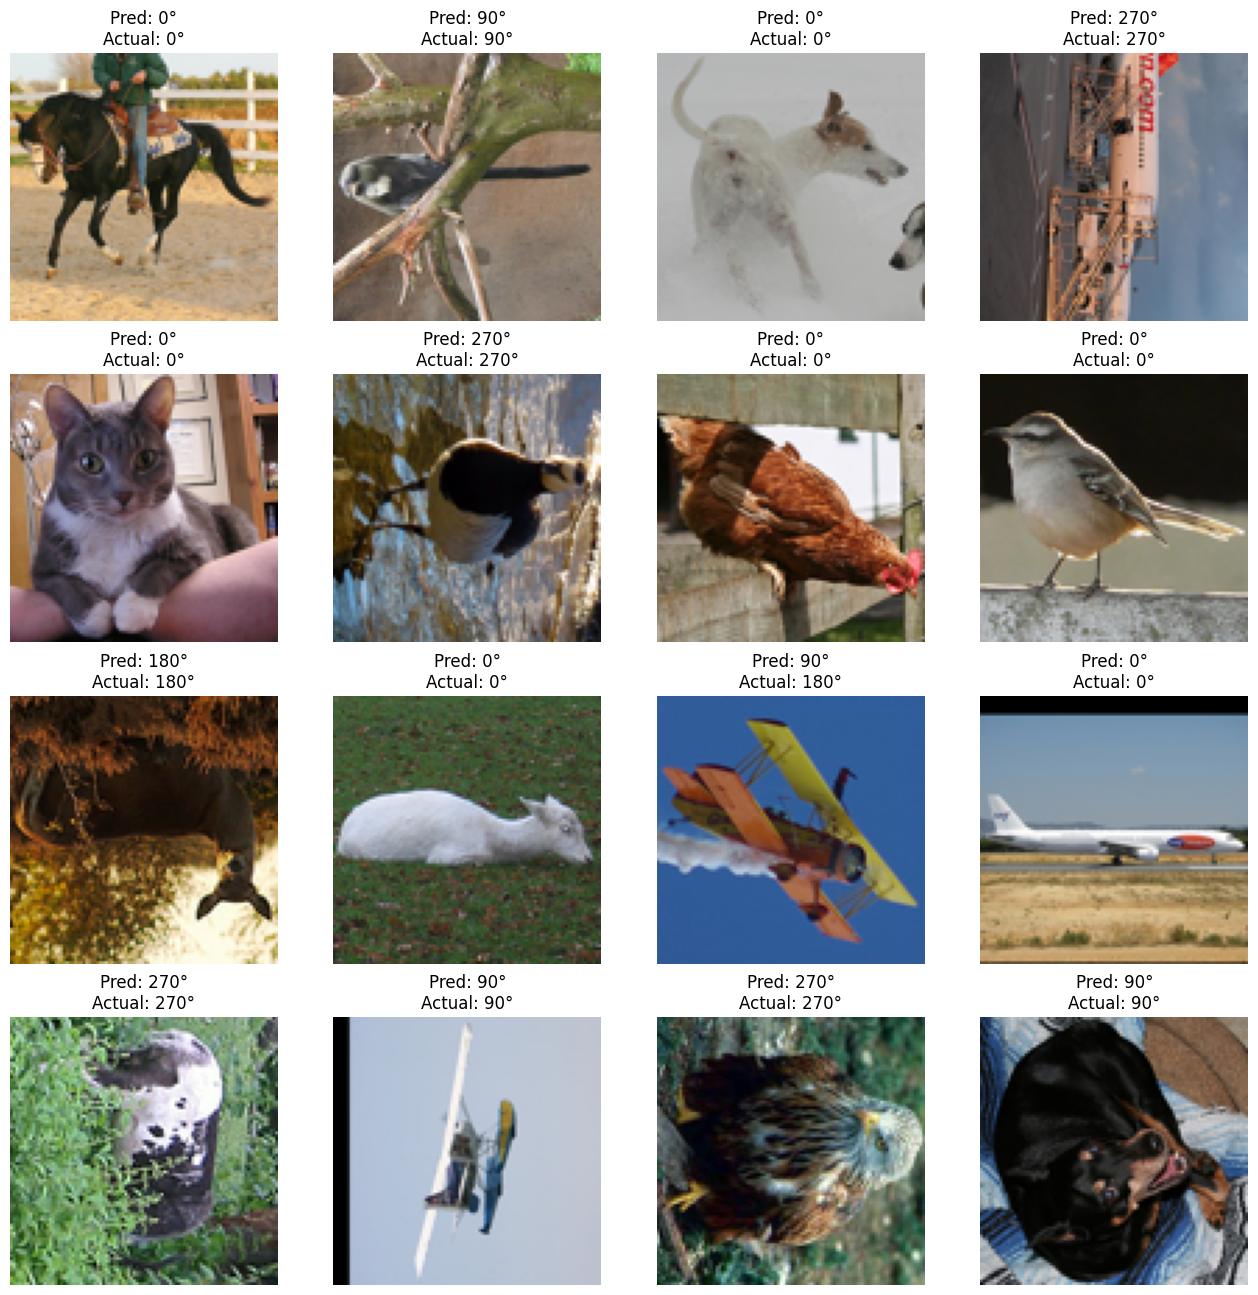

In [10]:
### START CODE HERE ### (~10 lines)
_, vis_val_dl = load_data(16)

with torch.inference_mode():
    model.eval()
    model.to(device)
    data, targets = next(iter(vis_val_dl))
    data, targets = data.to(device), targets.to(device)

    outputs = model(data)
    _, predicted = torch.max(outputs, 1)

    rotation_angles = lambda x: str(x * 90) + '°'

    predicted_angles = [rotation_angles(p.item()) for p in predicted]
    actual_angles = [rotation_angles(t.item()) for t in targets]

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))

    data = data.cpu().detach()

    for i, ax in enumerate(axes.flat):
        plt.sca(ax)
        imshow(data[i])
        ax.set_title(f'Pred: {predicted_angles[i]}\nActual: {actual_angles[i]}')
        ax.axis('off')

    plt.show()
### END CODE HERE ###

### Expected result

![](https://github.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/blob/main/exercises/week02/figs/viz_prediction_solution.png?raw=true)

# Task 5: Compute the validation rotation prediction accuracy

What percentage of image rotations is the model able to predict correctly? You should be able to achieve above 90%.

Use the validation split.

In [11]:
### START CODE HERE ### (~6 line of code)
val_acc, val_loss = validate(model, val_dl, device)
print(f'Val Accuracy: {val_acc:.2f}. Val Loss {val_loss:.3f}')
### END CODE HERE ###

Val Accuracy: 95.94. Val Loss 0.135


### Expected result

```
Val Accuracy 97.99 || Loss Val 0.070
```

# Task 6: Get the training features from the trained encoder

Save the representations and labels of the *labeled* train split and validiation split on the disk (you can use `utils.get_features`).
The names should be `"train_feats.pth", "val_feats.pth", "train_labels.pth", "val_labels.pth"`.
Note: here we only used the supervised training split.

In [12]:
### START CODE HERE ### (≈ 8 line of code)
train_dl, val_dl = load_data(train_split='train', rotated=False)

model.fc = nn.Identity()

train_feats, train_labels = get_features(model, train_dl, device)
val_feats, val_labels = get_features(model, val_dl, device)

os.makedirs('./features')
torch.save(train_feats, './features/train_feats.pth')
torch.save(train_labels, './features/train_labels.pth')
torch.save(val_feats, './features/val_feats.pth')
torch.save(val_labels, './features/val_labels.pth')
### END CODE HERE ###

# Task 7: Linear evaluation: Probing

For probing, you can use `linear_eval(classifier, optimizer, epochs, train_feat_dl, val_feat_dl, device)`.


Use the saved features and train a liner classifier on top on the **training split** of STL10.


In [13]:
### START CODE HERE ### (≈ 10 line of code)
num_epochs = 50
lr = 1e-3
batch_size = 128

train_ds, val_ds = TensorDataset(train_feats, train_labels), TensorDataset(val_feats, val_labels)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers)
val_dl = DataLoader(val_ds, batch_size, shuffle=False, num_workers=num_workers)

num_feats = train_feats.size(1)
num_classes = len(torch.unique(train_labels))

model = nn.Linear(num_feats, num_classes)
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [14]:
log = linear_eval(model, optimizer, num_epochs, train_dl, val_dl, device)

Init Accuracy of the model: Train:10.120 	 Val:10.037500


  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
idx = np.argmax(log['val_acc_epoch'])
print(f'Train Accuracy: {log['train_acc_epoch'][idx]}. Val Accuracy: {log['val_acc_epoch'][idx]}.')
### END CODE HERE ###

Train Accuracy: 60.959999084472656. Val Accuracy: 57.28750228881836.


### Expected results

```
Ep 49/50: Accuracy : Train:98.32 	 Val:98.41 || Loss: Train 0.160 	 Val 0.156: 100%|██████████| 50/50 [00:04<00:00, 11.74it/s]
```

# Task 8: Visualize the computed features with TSNE
- Color the points based on ground truth labels
- Hint: Use `from sklearn.manifold import TSNE`

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 1.225657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.629227
[t-SNE] KL divergence after 300 iterations: 2.824871


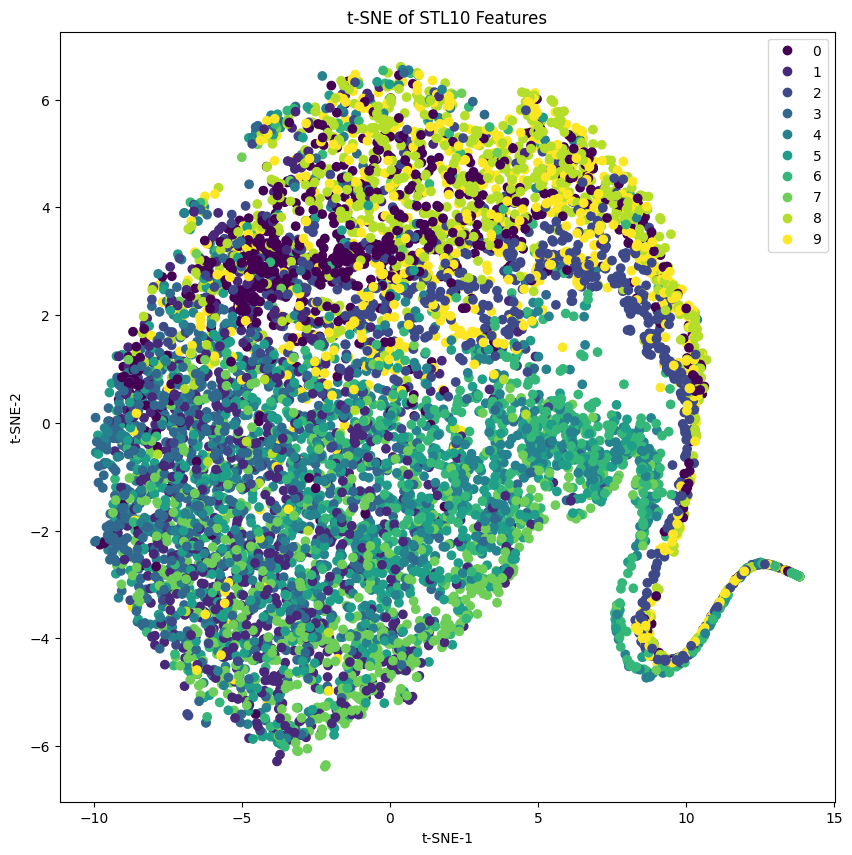

In [18]:
from sklearn.manifold import TSNE

### START CODE HERE ### (≈ 10 line of code)
def tsne_plot_embeddings(features, labels, class_names):
    model = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300)
    tsne_results = model.fit_transform(features)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
    plt.title('t-SNE of STL10 Features')
    plt.xlabel('t-SNE-1')
    plt.ylabel('t-SNE-2')

    plt.legend(*scatter.legend_elements())
    plt.show()
### END CODE HERE ###

val_feats, val_labels = torch.load("./features/val_feats.pth"), torch.load("./features/val_labels.pth")
class_names = torchvision.datasets.STL10(root='../data').classes
tsne_plot_embeddings(val_feats, val_labels, class_names)

### Expected result

![link text](https://github.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/blob/main/exercises/week02/figs/tsne_plot_embeddings_solution.png?raw=true)

# Conclusion and Bonus reads

Are the features visually seperable in the 2D space? Why is that?

That's the end of this exercise. If you reached this point, congratulations!

If you are interested to delve into this topic further, here are some links:

- [Self-supervised learning and computer vision](https://www.fast.ai/posts/2020-01-13-self_supervised.html)
- [Self-Supervised Representation Learning: Introduction, Advances and Challenges](https://arxiv.org/abs/2110.09327)

